**This is a tutorial of how easy it is to create images using freely available pretrained Generative Adversarial Networks (GANs)**

We're going to use Tensorflow Hub to load a pretrained BigGAN image generator network and produce some images with it.

**After you've read, run, and understood the code, try to modify it as follows:**
* Easy: Create images that blend two image classes. You can simply add together two different y vectors.
* Slightly harder: Interpolate between two images from different two classes. This can be done by interpolating between pairs of z and y vectors. If you've never done this, see here: https://gamedev.stackexchange.com/questions/18615/how-do-i-linearly-interpolate-between-two-vectors
* Advanced: load some target image, e.g., your own face. Define the module inputs as Tensorflow variables and optimize the variables to maximize the similarity between the generator output and the target image. In other words, find the latent space coordinates that make the generator generate an image of you. Once you know the coordinates, you can try interpolating between you and some other images. (No model solution provided for this yet!)

Model solutions are provided in the same folder, but first try to solve the problem yourself, at least for a few minutes. *Think of this as a puzzle game with optional hints that you will check only if you have to.*

As usual, we begin by importing everything we need. In addition to the usual suspects, we also include Tensorflow Hub, which is a service that allows loading some high-quality pretrained Tensorflow networks. 

Note that for some reason, my Jupyter gives me an error if I use GPU, even though I can run the same code from the command line. This is why I'm disabling the GPU. You might want to try removing that line.

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this out if your tensorflow works ok with GPU
import tensorflow as tf
import tensorflow_hub as hub

W0405 11:30:50.972985 10472 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Next, we load the BigGAN network module from Tensorflow Hub. We also print out some information about the inputs and outputs. We should see that the module wants z, y, and truncation inputs, and outputs a 'default' output. The shape of the output hints that this network generates a batch of 128x128 pixel images with 3 channels (RGB).

NOTE: this step may take about half a minute or more.

In [2]:
# Define the BigGAN model. The "128" means a 128x128 pixel model which is reasonably fast
# to run without a beefy GPU. There are also 256x256 and 512x512 models available
# Uncomment the one you want to test.
print("Loading BigGAN module")
module = hub.Module('https://tfhub.dev/deepmind/biggan-deep-128/1')
print("Module input info:")
print(module.get_input_info_dict())
print("Module output info:")
print(module.get_output_info_dict())


Loading BigGAN module
Module input info:
{'z': <hub.ParsedTensorInfo shape=(?, 128) dtype=float32 is_sparse=False>, 'y': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>, 'truncation': <hub.ParsedTensorInfo shape=() dtype=float32 is_sparse=False>}
Module output info:
{'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}


To be able to generate images, we need to add a few more Tensorflow ops and create and initialize a Tensorflow Session.

NOTE: this step may take about half a minute or more.

In [3]:
print("Creating the sampling ops")
# The generator needs two inputs: random noise (z) and ImageNet class label (y).
# We define placeholders for these, which will make it easy to do experiments after 
# everything has been initialized
yIn=tf.placeholder(dtype=tf.float32,shape=[None,1000])  #there are 1000 classes
zIn=tf.placeholder(dtype=tf.float32,shape=[None,128]) #these deep BigGAN models have as many latent dimensions as pixel width and height
truncationIn=tf.placeholder(dtype=tf.float32)#this is just a sincle floating point number

# This tensor will hold the samples
samples = module(dict(y=yIn, z=zIn, truncation=truncationIn))

# As always, we need to have a Tensorflow session and initialize the variables.
print("Creating the session")
sess=tf.Session()
print("Initializing variables")
tf.global_variables_initializer().run(session=sess)
print("Done! You should now be able to generate samples.")

Creating the sampling ops
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 11:31:27.550374 10472 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Creating the session
Initializing variables
Done! You should now be able to generate samples.


Now that everything has been initialized, the actual image generation should be reasonably fast. We only need to feed the network new z and y values to get new images. 

W0405 11:35:45.569925 10472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 11:35:45.586008 10472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 11:35:45.604028 10472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 11:35:45.630092 10472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


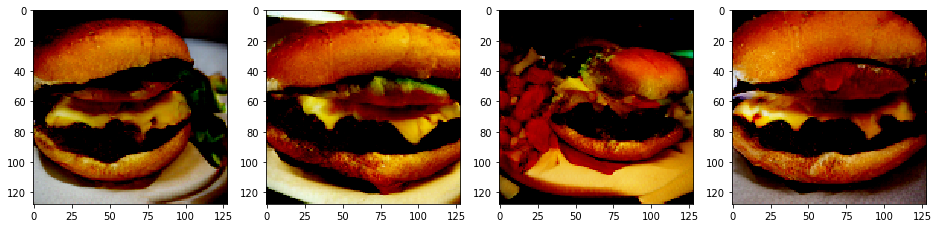

In [11]:
# This is just a helper to for creating one-hot numpy arrays
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

# We want this many images at a time
batch_size = 4

# First, let's define the label as a one-hot vector of 1000 values.
# 933 means a cheeseburger, as defined here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# As the network operates on batches, we must define the labels as batches too.
# This is why we can't simply pass '933' to np.one_hot(). Instead, we use a vector of constant values.  
y_index=np.full(shape=[batch_size],fill_value=933,dtype=np.int32)
y=one_hot(y_index,1000) 

#if you want a random label, you can uncomment the following two lines
#y_index=np.random.uniform([batch_size], maxval=1000, dtype=tf.int32)
#y = np.one_hot(y_index, 1000)  # one-hot ImageNet label

# Define how much variety we get.
truncation = 0.5    

# Now let's define the image variant: this is a N-dimensional vector that
# defines a position in the generator's "latent space"
N=128 #these deep BigGAN models have as many latent dimensions as pixel width and height
z = truncation*np.random.normal(size=[batch_size, N])  # random vector

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#We will view multiple images on a row: initialize the figure
pp.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    #This subplot() call creates a grid with 1 rows and batch_size columns.
    #It also makes the following imshow() update the i:th image.
    pp.subplot(1,batch_size,1+i)
    pp.imshow(samples_fetched[i])